In [7]:
import scirpy as ir
import scanpy as sc
import muon as mu
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from collections import Counter

import warnings

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu("../data/tcr_data/121c_clone_id_full.h5mu")

In [9]:
mdata["gex"].obs["pt_day"] = mdata["gex"].obs["ID"].astype(str) + ": " + mdata["gex"].obs["day_label"].astype(str)
mdata.update_obs()

tcr_adata = mdata[mdata["airr"].obs["receptor_type"] == "TCR"].copy()
bcr_adata = mdata[mdata["airr"].obs["receptor_type"] == "BCR"].copy()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
with ir.get.airr_context(tcr_adata, "v_call") as m:
    vj = (
        m.obs.groupby(["gex:ID", "gex:day_label", "VJ_1_v_call"], observed=True)
        .size()
        .reset_index(name="n")
    )
    vdj = (
        m.obs.groupby(["gex:ID", "gex:day_label", "VDJ_1_v_call"], observed=True)
        .size()
        .reset_index(name="n")
    )
    combinations = (
        m.obs.groupby(["gex:ID", "gex:day_label", "VJ_1_v_call", "VDJ_1_v_call"], observed=True)
        .size()
        .reset_index(name="n")
    )

In [17]:
gene_df = vj
col_key = "VJ_1_v_call"

top_rows = []

# Calculate Percent abundance per sample.
pcts = []
for sp, subset in vj.groupby(["gex:ID", "gex:day_label"]):
    total = subset["n"].sum()
    pcts.append((subset["n"] / total) * 100)

gene_df["percent_abundance"] = pd.concat(pcts)

for id, subset in gene_df.groupby(["gex:ID", "gex:day_label"]):
        top_rows.append(subset.sort_values("percent_abundance", ascending=False).iloc[:20])

df = pd.concat(top_rows)

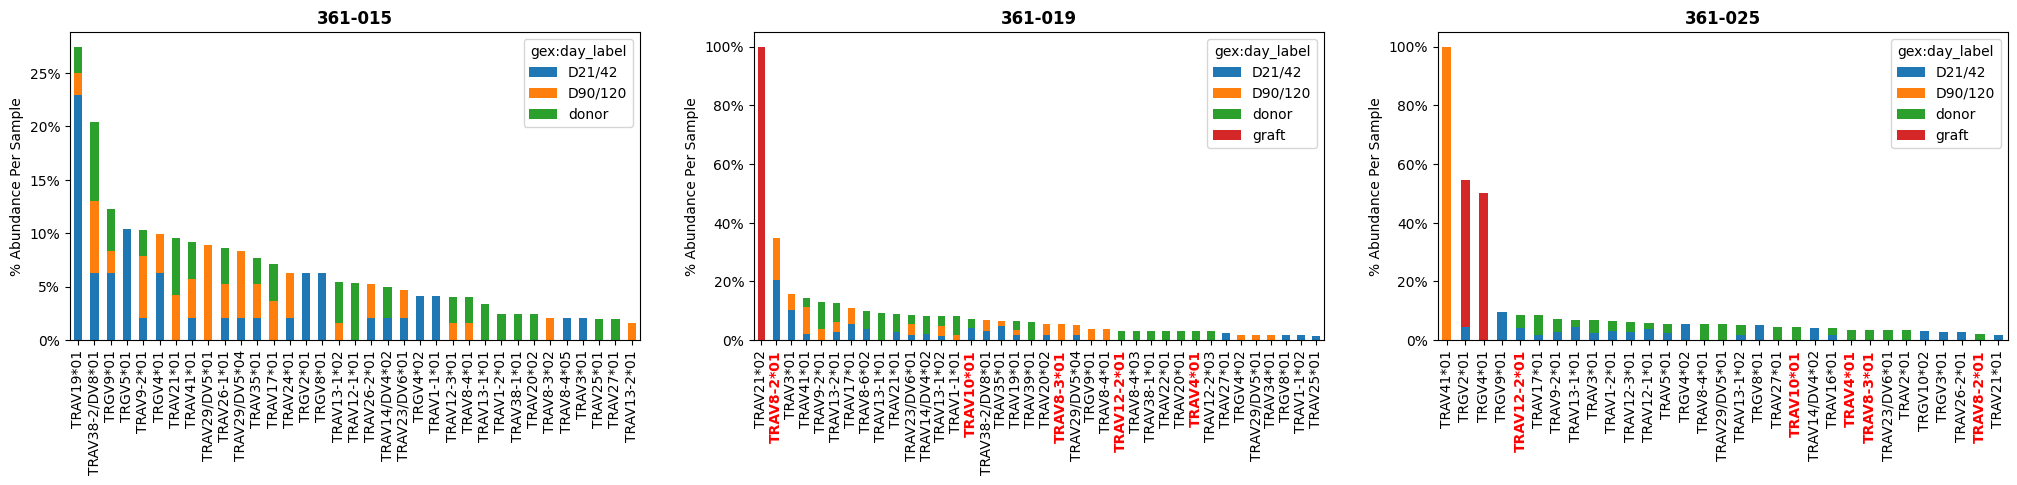

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 4))
xtick_label_counter = Counter()
control_group = set()

## Get the control group
for pt_id, data in df.groupby("gex:ID"):
    if pt_id == "361-015":
        control_group.update(data[col_key])

i= 0
for pt_id, data in df.groupby("gex:ID"):
    ax = axs[i]
    tmp = data.pivot_table(columns="gex:day_label", index=col_key, values="percent_abundance", sort=False).fillna(0)

    tmp['mean'] = tmp.mean(axis=1)
    tmp = tmp.sort_values('mean', ascending=False)
    tmp.drop(columns="mean", inplace=True)
    ax = tmp.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(pt_id)
    ax.set_ylabel("% Abundance Per Sample")
    ax.set_xlabel("")

    xtick_label_counter.update(set(tmp.index) - control_group)
    
    i += 1
    # Reorder Legend
    order = [2, 3, 0, 1]
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(
    #     [handles[idx] for idx in order],
    #     [labels[idx] for idx in order]
    # )
    ax.title.set(fontweight="bold")
    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

for ax in axs:
    xticks = ax.get_xmajorticklabels()

    for xtick in xticks:
        text = xtick.get_text()
        if xtick_label_counter[text] >= 2:
            xtick.set_color("red")
            xtick.set(fontweight="bold")

### Combinations of V(D)J genes at the variable region

In [19]:
from collections import defaultdict as dd

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_79866/1659911259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["v_gene_combined"] =  df["VJ_1_v_call"].astype(str) + "-" + df["VDJ_1_v_call"].astype(str)


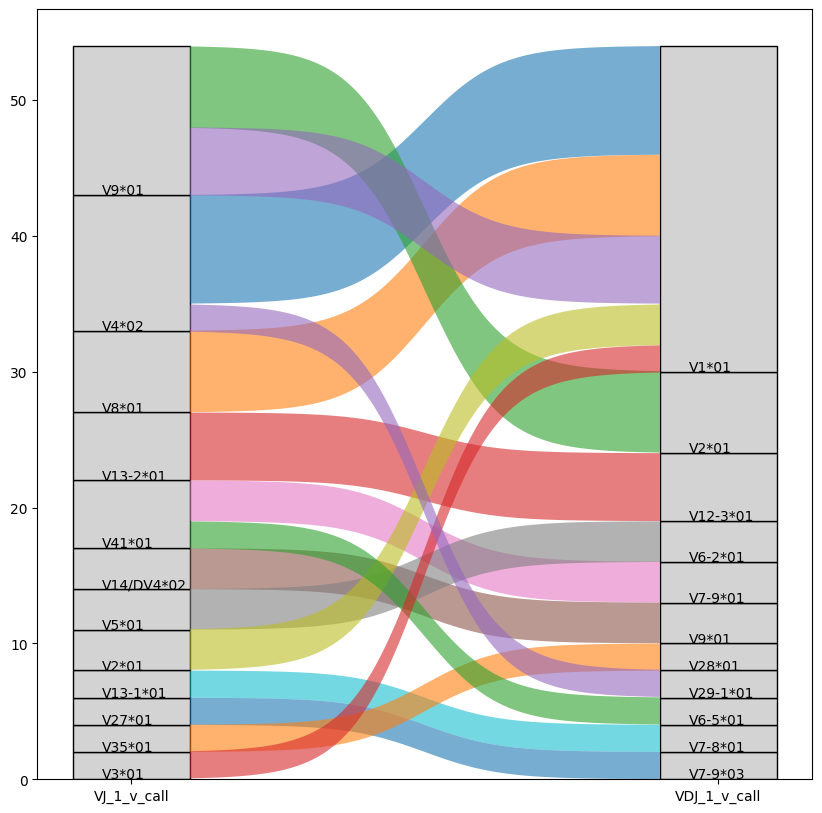

In [20]:
with ir.get.airr_context(tcr_adata, "v_call", ["VJ_1", "VDJ_1"]):
    indices = list(tcr_adata.obs[["VJ_1_v_call", "VDJ_1_v_call"]].dropna().index)
    rows = tcr_adata.obs_names.isin(indices)

    # Grab only the GvHD patients
    pt_id = tcr_adata.obs["gex:ID"].isin(["361-025", "361-019"])
    df = tcr_adata.obs[rows & pt_id]
    gvhd = tcr_adata[rows & pt_id].copy()

    shared_genes = set()
    df["v_gene_combined"] =  df["VJ_1_v_call"].astype(str) + "-" + df["VDJ_1_v_call"].astype(str)
    for _, genes in df.groupby("gex:ID")["v_gene_combined"]:
        if shared_genes:
            shared_genes.intersection_update(set(genes))
        else:
            shared_genes.update(set(genes))
            
    keep_shared = df["v_gene_combined"].isin(shared_genes)
    
    
    ax = ir.pl.vdj_usage(
    gvhd[keep_shared],
    full_combination=True,
    max_segments=None,
    vdj_cols=('VJ_1_v_call', 'VDJ_1_v_call'),
    max_labelled_segments=25,
    max_ribbons=30,
    fig_kws={"figsize": [10, 10]},
    barwidth=0.2,
    )

In [21]:
with ir.get.airr_context(tcr_adata, "v_call", ["VJ_1", "VDJ_1"]):
    df = tcr_adata.obs
    df["v_gene_combined"] =  df["VJ_1_v_call"].astype(str) + "-" + df["VDJ_1_v_call"].astype(str)
    df = df[df["v_gene_combined"].isin(shared_genes)]
    df = df[~df["gex:ID"].isna()]

vj_count = {}
vdj_count = {}

for pt_id, subset in df.groupby("gex:ID"):
    vj_count[pt_id] = (subset["VJ_1_v_call"].value_counts())
    vdj_count[pt_id] = (subset["VDJ_1_v_call"].value_counts())

In [22]:
vj_df = pd.DataFrame(vj_count)
vj_df["Total"] = vj_df.sum(axis=1)
vj_df.sort_values("Total", ascending=False, inplace=True)
vj_df = vj_df[vj_df["Total"] > 0]
vj_df.index.name=None
vj_df

,361-015,361-019,361-025,Total
TRGV9*01,6,5,6,17
TRGV4*02,3,2,8,13
TRGV8*01,0,5,1,6
TRGV2*01,3,1,2,6
TRAV41*01,1,3,2,6
TRAV13-2*01,0,4,1,5
TRAV5*01,0,1,2,3
TRGV3*01,1,1,1,3
TRAV14/DV4*02,0,1,2,3
TRAV27*01,0,1,1,2


In [23]:
vdj_df = pd.DataFrame(vdj_count)
vdj_df["Total"] = vdj_df.sum(axis=1)
vdj_df.sort_values("Total", ascending=False, inplace=True)
vdj_df = vdj_df[vdj_df["Total"] > 0]
vdj_df.index.name=None
vdj_df

,361-015,361-019,361-025,Total
TRDV1*01,11,12,12,35
TRDV2*01,2,1,5,8
TRBV12-3*01,0,4,1,5
TRBV6-5*01,1,1,1,3
TRBV7-9*01,0,2,1,3
TRBV9*01,0,1,2,3
TRBV6-2*01,0,1,2,3
TRBV7-8*01,0,1,1,2
TRBV29-1*01,0,1,1,2
TRBV28*01,0,1,1,2


In [24]:
vj_gene = "TRAV14/DV4*02"
vdj_gene = "TRBV9*01"

In [25]:
with ir.get.airr_context(tcr_adata, "v_call", ["VJ_1", "VDJ_1"]):
    df = tcr_adata.obs[["VJ_1_v_call", "VDJ_1_v_call", "gex:consensus_celltype", "airr:is_full_chain"]]
    umap = pd.DataFrame(tcr_adata["gex"].obsm["X_umap"], columns=["UMAP1", "UMAP2"], index=tcr_adata.obs_names)
    df = df.join(umap)
    df = df[df["airr:is_full_chain"]]

vj_tar_df = df[df["VJ_1_v_call"] == vj_gene]
vj_tar_df["VJ_1_v_call"] = vj_tar_df["VJ_1_v_call"].astype(str)
vdj_tar_df = df[df["VDJ_1_v_call"] == vdj_gene]
vdj_tar_df["VDJ_1_v_call"] = vj_tar_df["VDJ_1_v_call"].astype(str)

/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_79866/1051891909.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vj_tar_df["VJ_1_v_call"] = vj_tar_df["VJ_1_v_call"].astype(str)
/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_79866/1051891909.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdj_tar_df["VDJ_1_v_call"] = vj_tar_df["VDJ_1_v_call"].astype(str)


Text(0.5, 1.0, 'TRBV9*01')

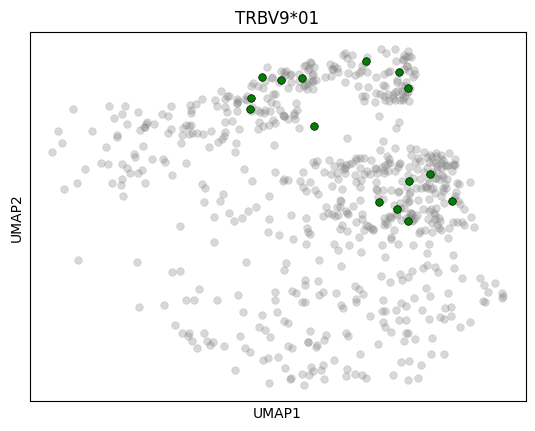

In [26]:
ax = sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, color="grey", edgecolor=None, alpha=0.3)
sns.scatterplot(data=vdj_tar_df, x="UMAP1", y="UMAP2", s=30, color="green", ax= ax, edgecolor="black")

ax.set_yticks([])
ax.set_xticks([])

ax.set_title("TRBV9*01")

Text(0.5, 1.0, 'TRAV14/DV4*02')

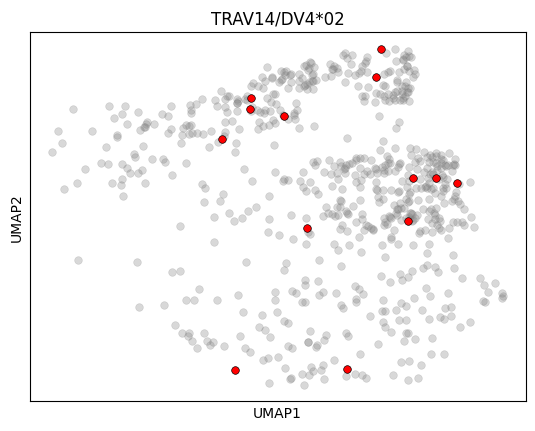

In [27]:
ax1 = sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, color="grey", edgecolor=None, alpha=0.3)
sns.scatterplot(data=vj_tar_df, x="UMAP1", y="UMAP2", s=30, color="red", ax= ax1, edgecolor="black")


ax1.set_yticks([])
ax1.set_xticks([])

ax1.set_title("TRAV14/DV4*02")

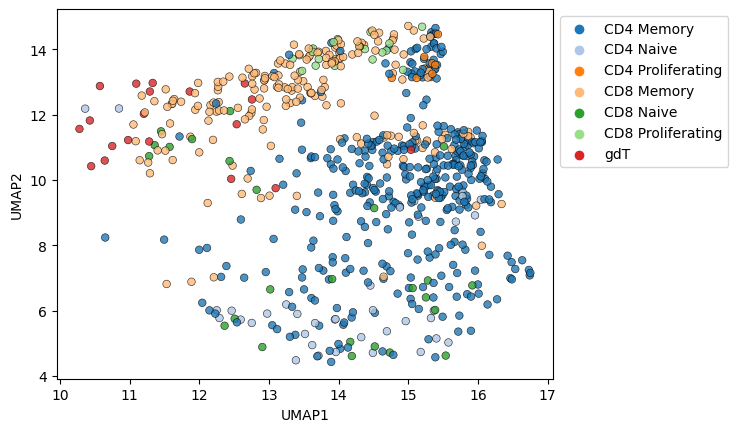

In [28]:
df["gex:consensus_celltype"] = df["gex:consensus_celltype"].cat.remove_unused_categories()
ax = sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, palette="tab20", alpha=0.8, hue="gex:consensus_celltype", edgecolor="black")
ax.legend(bbox_to_anchor=(1, 1))